In [1]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


# .env 読み込み
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")


..\environment\.env
ログイン試行中 → username: 'y-nitta@torishima.co.jp'
✅ ログイン成功


In [2]:

# データ取得
url = "https://metabase.tr-com.net/api/card/2090/query/json"
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "sensorid"]],
            "value": "VB39BA0C"
        }
    ]
}


In [3]:

response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        dfori = pd.DataFrame(data)
        if dfori.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(dfori.head())

    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


✅ データ取得成功
   sensorid                   UserId            TimeStamp  \
0  VB39BA0C  maruni-k@marunetu.co.jp  2020-10-04T04:16:20   
1  VB39BA0C  maruni-k@marunetu.co.jp  2020-10-04T04:20:49   
2  VB39BA0C  maruni-k@marunetu.co.jp  2020-10-11T01:05:36   
3  VB39BA0C  maruni-k@marunetu.co.jp  2020-10-18T00:26:37   
4  VB39BA0C  maruni-k@marunetu.co.jp  2020-10-18T00:40:52   

            recordDate     VRMSX   VRMSXAcc  Temperature  
0  2020-10-04T04:16:20  0.050394  28.346457        22.13  
1  2020-10-04T04:20:49  0.050394  28.346457        22.13  
2  2020-10-11T01:05:36  0.044094  29.133858        20.27  
3  2020-10-18T00:26:37  0.051969  31.102362        18.70  
4  2020-10-18T00:40:52  0.051969  31.102362        18.52  


In [4]:
dfori

,sensorid,UserId,TimeStamp,recordDate,VRMSX,VRMSXAcc,Temperature
0,VB39BA0C,maruni-k@marunetu.co.jp,2020-10-04T04:16:20,2020-10-04T04:16:20,0.050394,28.346457,22.13
1,VB39BA0C,maruni-k@marunetu.co.jp,2020-10-04T04:20:49,2020-10-04T04:20:49,0.050394,28.346457,22.13
2,VB39BA0C,maruni-k@marunetu.co.jp,2020-10-11T01:05:36,2020-10-11T01:05:36,0.044094,29.133858,20.27
3,VB39BA0C,maruni-k@marunetu.co.jp,2020-10-18T00:26:37,2020-10-18T00:26:37,0.051969,31.102362,18.70
4,VB39BA0C,maruni-k@marunetu.co.jp,2020-10-18T00:40:52,2020-10-18T00:40:52,0.051969,31.102362,18.52
...,...,...,...,...,...,...,...
438,VB39BA0C,maruni-k@marunetu.co.jp,2025-05-18T00:51:22,2025-05-18T00:51:22,0.055512,15.354331,20.94
439,VB39BA0C,maruni-k@marunetu.co.jp,2025-05-25T00:37:11,2025-05-25T00:37:11,0.055512,16.141732,18.43
440,VB39BA0C,maruni-k@marunetu.co.jp,2025-05-25T00:51:31,2025-05-25T00:51:31,0.055512,15.748031,18.24
441,VB39BA0C,maruni-k@marunetu.co.jp,2025-05-25T01:12:01,2025-05-25T01:12:01,0.055512,15.748031,18.24


=== 自動生成された分類ルール ===
|--- VRMSXAcc <= 19.09
|   |--- class: 0
|--- VRMSXAcc >  19.09
|   |--- class: 1



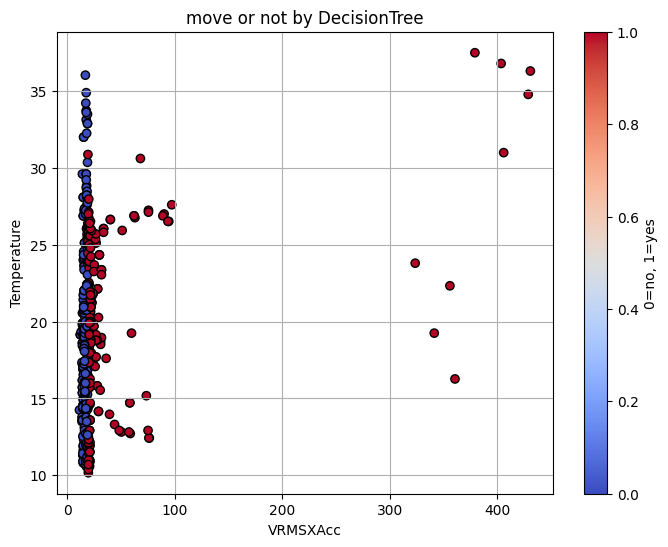

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split


# ② 特徴量と仮ラベル作成（仮のしきい値でラベルを付けて学習）
# ※ 本来は正解ラベルがあると理想だが、今回は自動分類ルール抽出が目的
X = dfori[['VRMSXAcc', 'Temperature']].copy()
y = (dfori['VRMSXAcc'] > dfori['VRMSXAcc'].median()).astype(int)  # 中央値で仮の2クラス分類

# ③ 学習用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ④ 決定木モデル作成
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# ⑤ 分類ルールを表示（自動で学習された「しきい値」付き）
rules = export_text(clf, feature_names=['VRMSXAcc', 'Temperature'])
print("=== 自動生成された分類ルール ===")
print(rules)

# ⑥ 分類結果を2Dで可視化
plt.figure(figsize=(8, 6))
plt.scatter(X['VRMSXAcc'], X['Temperature'], c=clf.predict(X), cmap='coolwarm', edgecolors='k')
plt.xlabel('VRMSXAcc')
plt.ylabel('Temperature')
plt.title('move or not by DecisionTree')
plt.colorbar(label='0=no, 1=yes')
plt.grid(True)
plt.show()


C:\Users\H6445\AppData\Local\Temp\ipykernel_17688\3542238400.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfori['diff1'] = dfori['VRMSXAcc'].diff().fillna(0)                   # 一次変化量（速度）
C:\Users\H6445\AppData\Local\Temp\ipykernel_17688\3542238400.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfori['diff2'] = dfori['diff1'].diff().fillna(0)                      # 二次変化量（加速度）
C:\Users\H6445\AppData\Local\Temp\ipykernel_17688\3542238400.py:16: SettingWithCopyWarning: 
A value is trying to be se

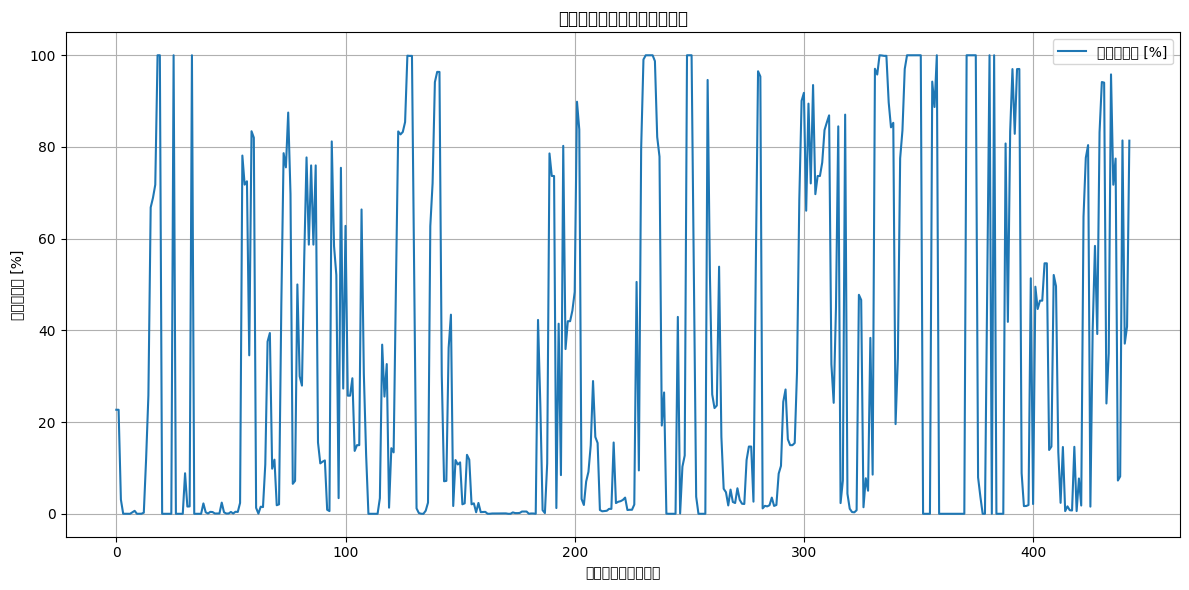

     VRMSXAcc  move_percent
0   28.346457  2.268966e+01
1   28.346457  2.268966e+01
2   29.133858  3.097417e+00
3   31.102362  1.346931e-02
4   31.102362  7.514849e-03
5   31.889764  1.141403e-03
6   36.220472  1.696913e-08
8   27.952756  6.459996e-01
9   19.685039  1.236036e-03
10  19.685039  3.174294e-03


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from scipy.special import expit  # シグモイド関数で差を強調
import matplotlib.pyplot as plt
import seaborn as sns

# --- 前処理 ---
dfori = dfori.dropna(subset=['VRMSXAcc', 'Temperature'])

# --- 特徴量生成 ---
dfori['diff1'] = dfori['VRMSXAcc'].diff().fillna(0)                   # 一次変化量（速度）
dfori['diff2'] = dfori['diff1'].diff().fillna(0)                      # 二次変化量（加速度）
dfori['rolling_mean'] = dfori['VRMSXAcc'].rolling(window=5, min_periods=1).mean()
dfori['volatility'] = dfori['VRMSXAcc'].rolling(window=5, min_periods=1).std().fillna(0)
dfori['Temperature_rolling'] = dfori['Temperature'].rolling(window=5, min_periods=1).mean()

# --- クラスタリング（モード識別） ---
kmeans = KMeans(n_clusters=4, random_state=42)
dfori['cluster'] = kmeans.fit_predict(dfori[['VRMSXAcc']])
cluster_centers = kmeans.cluster_centers_
dfori['dist_to_center'] = np.linalg.norm(
    dfori[['VRMSXAcc']].values - cluster_centers[dfori['cluster']], axis=1
)

# --- 異常検知 ---
iso = IsolationForest(contamination=0.02, random_state=42)
dfori['anomaly'] = iso.fit_predict(dfori[['VRMSXAcc', 'diff1', 'volatility']])  # -1: 異常, 1: 正常

# --- 正規化 ---
scaler = MinMaxScaler()
dfori[['VRMSXAcc_norm', 'trend_norm', 'volatility_norm', 'dist_norm']] = scaler.fit_transform(
    dfori[['VRMSXAcc', 'diff1', 'volatility', 'dist_to_center']]
)

# --- 稼働スコアの計算（重みづけ） ---
dfori['move_score'] = (
    0.4 * dfori['VRMSXAcc_norm'] +           # 高い振動 → 稼働
    0.2 * dfori['trend_norm'] +              # 上昇傾向 → 稼働
    0.2 * (1 - dfori['volatility_norm']) +   # 安定してる → 稼働
    0.2 * (1 - dfori['dist_norm'])           # クラスタ中心に近い → 稼働
)

# --- 差の強調（シグモイド関数） ---
dfori['move_score_adjusted'] = expit(1000 * (dfori['move_score'] - 0.5))  # 中央から離れると急激に変化
dfori['move_percent'] = (dfori['move_score_adjusted'] * 100).clip(0, 100)

# --- 可視化 ---
plt.figure(figsize=(12,6))
plt.plot(dfori['move_percent'], label='稼働スコア [%]')
plt.xlabel('時系列インデックス')
plt.ylabel('稼働スコア [%]')
plt.title('総合稼働スコア（差を強調）')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# --- 確認出力（先頭10行）---
print(dfori[['VRMSXAcc', 'move_percent']].head(10))
